### Load packages and sample data

In [1]:
import shlex
import re
import pandas as pd
from typing import List
import utils

In [2]:
fields_to_include = ["OWNER","TITLE", "ABSTRACT", "SERVICETYPE", "SERVICELINK", "KEYWORDS"]
fields_to_output = ["OWNER","TITLE", "SERVICETYPE", "SERVICELINK"]
url_github_repo = "https://github.com/davidoesch/geoservice_harvester_poc/blob/main/data/"
url_github_repo_suffix = "?raw=true"
url_geoservices_CH_csv = "{}geoservices_CH.csv{}".format(url_github_repo,url_github_repo_suffix)
a = 'Strassen auswertung system'

def split_delimiters(word_list_with_delimiters: List[str]) -> List[str]:
    """Take care of left over delimiters, split strings even if in qoutes
        Return a list of words """
    delimiters = [";", ","]

    new_word_list = []

    for word in word_list_with_delimiters:
        if (any(delimiter in word for delimiter in delimiters)):
            splitted_words = re.split(r',|;', word)
            for splitted_word_ in splitted_words:
                new_word_list.append(splitted_word_)
        else:
            new_word_list.append(word)
    return new_word_list

def load_data():
    dataframe = pd.read_csv(url_geoservices_CH_csv, usecols=fields_to_include)
    return dataframe

res = split_delimiters(shlex.split(a))
dataframe_some_cols = load_data()
result = dataframe_some_cols[dataframe_some_cols.apply(lambda dataset: dataset.astype(str).str.contains(res[0], case=False).any(), axis=1)]
database =result.fillna("empty")

### Improvement of the TF-IDF with BM25 to execute queries on the text

In [7]:
# abstracts = result['ABSTRACT'].values.tolist()
bm25 = utils.TFIDF_BM25()
bm25.cleansing_ranking(database, column='ABSTRACT') # 1421 lines in 36 s

In [6]:
# fit the vector to the database
bm25.fit()
# search the best match in the vector
res = bm25.search('Brandmeldeanlage')

In [7]:
for el in res:
    print(result.loc[el])

OWNER                                                      KT_AR
TITLE                                          Feuerwehrplan Gde
ABSTRACT       Der Übersichtsplan der Feuerwehr enthält folge...
KEYWORDS                                                     NaN
SERVICELINK    https://www.geoportal.ch/services/wms/ktar?ser...
SERVICETYPE                                                  WMS
Name: 224, dtype: object


### Keyword extraction with rake_nltk (uses TF-IDF as well)

In [24]:
rake = utils.KeywordsRake()
keywords = rake.extract_keywords(database, column='ABSTRACT', score=False, keyword_length=3)

In [27]:
keywords[0][:10]

['wms service geoportal',
 'kanton appenzell innerrhoden',
 'meteorwasser sowie versickerungsanlagen',
 'karte zeigt',
 'kanalisationsnetz dargestellt',
 'darin ersichtlich',
 'sowie',
 'ölabscheider',
 'werkleitungen',
 'teilweise']

In [26]:
database['ABSTRACT'].values.tolist()[10]

"Die Karte zeigt, welcher Lärmbelastung die Bevölkerung durch den Strassenverkehr in der Nacht ausgesetzt ist. Die Angaben basieren auf flächendeckenden Modellberechnungen (sonBASE). Das gesamte Strassennetz der Schweiz, das in diese Berechnung einbezogen wurde, umfasst ca. 68'000 km. Die Verkehrsdaten für den Strassenverkehr wurden mit einem Mobilitätsmodell für das Jahr 2015 ermittelt. Die so ermittelten Verkehrsdaten wurden auf der Grundlage von ca. 1900 nationalen und kantonalen Zählstellen mit stundenfeinen Zählwerten kalibriert. Daten sind gesetzlich nicht verbindlich. Verbindliche Angaben zur Belastung wie auch zur Lärmsanierung geben die jeweiligen Vollzugsbehörden. Bei Nationalstrassen: Bundesamt für Strassen (ASTRA). Bei Haupt- und übrige Strassen: Die Kantonalen Vollzugsbehörden. WMS Service Geoportal - Kanton Appenzell Innerrhoden"

### Implement the classification and keyword extraction with spacy (NLP)

In [22]:
NLP = utils.NLP_spacy()
# Keyword
keywords_NLP = NLP.extract_keywords(database, column='ABSTRACT') # with small models

In [28]:
keywords_NLP[0]

[Geoportal]

In [15]:
# Original abstract
database['ABSTRACT'].values.tolist()[0]

'Diese Karte zeigt die Werkleitungen der Abwasserentsorgung an. Es wird die Strassenentwässerung und Liegenschaftsentwässerung (teilweise mit Hausanschluss) sowie das Kanalisationsnetz dargestellt. Darin ersichtlich sind unter anderem Leitungen mit Schmutzabwasser, Mischabwasser, Regenabwasser, Meteorwasser sowie Versickerungsanlagen, Kontrollschächte, Einlaufschächte und Ölabscheider. WMS Service Geoportal - Kanton Appenzell Innerrhoden'

### Test LSA and LSI with gensim for topic modelling

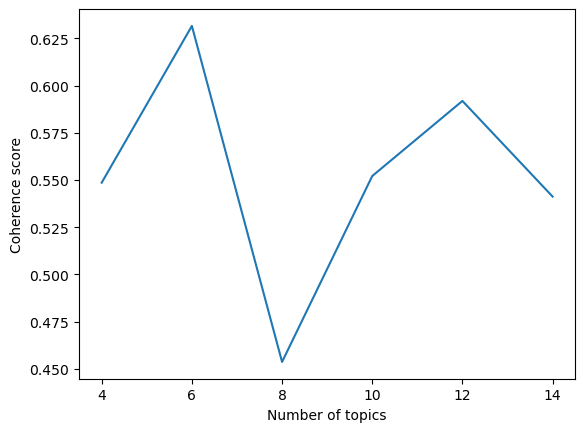

In [11]:
LSA = utils.LSI()
abstracts = LSA.preprocess(database)
#LSA.compute_coherence_values((4,16,2))

In [14]:
best_number_topics = 12
number_of_words = 10
lsamodel = LSA.create_gensim_lsa_model(best_number_topics, number_of_words)

[(0, '-0.439*"art" + -0.432*"tvav" + -0.239*"enthalt" + -0.209*"dateneb" + -0.199*"definiert" + -0.192*"punkt" + -0.172*"fehl" + -0.172*"mittl" + -0.172*"toleranzstuf" + -0.172*"standardabweich"'), (1, '0.416*"kanton" + 0.293*"wurd" + 0.281*"bern" + 0.233*"datensatz" + 0.230*"https" + 0.209*"//geofiles.be.ch/geoportal/pub/vertrieb/agi_dv_nutzungsbedingungen_de.pdf" + 0.147*"\'\'" + 0.146*"``" + 0.137*"gemass" + 0.129*"fff"'), (2, '0.435*"sitz" + -0.336*"\'\'" + -0.334*"``" + 0.326*"bern" + -0.306*"datensatz" + 0.148*"https" + 0.142*"//geofiles.be.ch/geoportal/pub/vertrieb/agi_dv_nutzungsbedingungen_de.pdf" + 0.125*"regionalgericht" + 0.094*"thun" + 0.094*"grenz"'), (3, '-0.508*"fff" + 0.293*"wurd" + 0.211*"\'\'" + 0.210*"``" + -0.187*"sachplan" + 0.156*"gewasserraum" + 0.152*"sitz" + -0.135*"gemass" + -0.127*"fruchtfolgeflach" + -0.120*"flach"'), (4, '0.355*"sitz" + 0.309*"datensatz" + -0.308*"gewasserraum" + -0.283*"wurd" + -0.191*"nutzungseinschrank" + 0.152*"\'\'" + 0.151*"``" + -0.

In [15]:
lsamodel.print_topics(best_number_topics, number_of_words)

[(0,
  '-0.439*"art" + -0.432*"tvav" + -0.239*"enthalt" + -0.209*"dateneb" + -0.199*"definiert" + -0.192*"punkt" + -0.172*"fehl" + -0.172*"mittl" + -0.172*"toleranzstuf" + -0.172*"standardabweich"'),
 (1,
  '0.416*"kanton" + 0.293*"wurd" + 0.281*"bern" + 0.233*"datensatz" + 0.230*"https" + 0.209*"//geofiles.be.ch/geoportal/pub/vertrieb/agi_dv_nutzungsbedingungen_de.pdf" + 0.147*"\'\'" + 0.146*"``" + 0.137*"gemass" + 0.129*"fff"'),
 (2,
  '0.435*"sitz" + -0.336*"\'\'" + -0.334*"``" + 0.326*"bern" + -0.306*"datensatz" + 0.148*"https" + 0.142*"//geofiles.be.ch/geoportal/pub/vertrieb/agi_dv_nutzungsbedingungen_de.pdf" + 0.125*"regionalgericht" + 0.094*"thun" + 0.094*"grenz"'),
 (3,
  '-0.508*"fff" + 0.293*"wurd" + 0.211*"\'\'" + 0.210*"``" + -0.187*"sachplan" + 0.156*"gewasserraum" + 0.152*"sitz" + -0.135*"gemass" + -0.127*"fruchtfolgeflach" + -0.120*"flach"'),
 (4,
  '0.355*"sitz" + 0.309*"datensatz" + -0.308*"gewasserraum" + -0.283*"wurd" + -0.191*"nutzungseinschrank" + 0.152*"\'\'" + 0.

### Test Text Summarization and Latent Dirchlet allocation (LDA) for topic modeling

In [16]:
# TODO
# https://towardsdatascience.com/text-summarization-for-clustering-documents-2e074da6437a
# https://towardsdatascience.com/nlp-topic-modeling-to-identify-clusters-ca207244d04f

In [3]:
NLP = utils.NLP_spacy()
topics = NLP.extract_topics_from_keywords(database, use_rake=True, column='ABSTRACT',
                                          keyword_length=3, num_keywords=3)
len(topics)
# BUG: the topics must be refined manually!!!

In [7]:
list(topics)

['wichtigste instrument',
 'mittelgründige rutschgebiete ab',
 'gebäude wichtiger standorte',
 'projektierte liegenschaften',
 'zuständigkeitsbereich',
 'baulinien tragen',
 'schweizmobil routen',
 'strassenlaermbeurteilung',
 'wirtschaftspolitischen kriterien fest',
 'dtv none',
 'drei erhebungen berücksicht',
 'wanderwegnetzes',
 'ab geschossnester ).',
 'https :// geofiles',
 'nächsten 30 jahre',
 'stundensteine',
 'stark befahrene bahnstrecken',
 'optimierungen detailliert beschrieben',
 '48162bb79ab9 link',
 'elektro leitungen none',
 'strassenprojekte none',
 'mutmasslich belastetem bodenaushub',
 'öffentliche sicherheit',
 'meldungen erfolgen',
 'planeinteilung',
 'alleen darf maximal',
 'gewässerbaulinien abgeleitet',
 'linienbezogenen festlegungen gehören',
 'agglomerationen bildet ab',
 'einzelnen aufnahmepunkte sicherzustellen',
 'sechs verschiedenen kategorien',
 'folgenden festsetzungen enthalten',
 'visualisierung',
 'primarschulen',
 'grober erfassung ),',
 'landwert inn

In [3]:
NLP = utils.NLP_spacy()
doc_labels, doc_dependencies = NLP.text_analysis(database['ABSTRACT'].values.tolist()[10])

In [4]:
doc_labels

label                                      text
0   LOC                                   Schweiz
1  MISC                                 Jahr 2015
2   ORG  Nationalstrassen: Bundesamt für Strassen
3  MISC          Die Kantonalen Vollzugsbehörden.
4   LOC                                 Geoportal

In [9]:
doc_dependencies[doc_dependencies['positional'] == 'NOUN']

text             lemma grammar  dependency positional
0                Karte             Karte      sb       zeigt       NOUN
2        Lärmbelastung     Lärmbelastung      da  ausgesetzt       NOUN
3          Bevölkerung       Bevölkerung      sb         ist       NOUN
5      Strassenverkehr   Strassenverkehr      nk       durch       NOUN
7                Nacht             Nacht      nk          in       NOUN
10             Angaben            Angabe      sb    basieren       NOUN
14  Modellberechnungen  Modellberechnung      nk         auf       NOUN
17        Strassennetz      Strassennetz      sb     umfasst       NOUN
21          Berechnung        Berechnung      nk          in       NOUN
27                  km                km      oa     umfasst       NOUN
28       Verkehrsdaten       Verkehrsdat      sb      wurden       NOUN
30     Strassenverkehr   Strassenverkehr      nk         für       NOUN
33    Mobilitätsmodell  Mobilitätsmodell      nk         mit       NOUN
35                Jahr              Jahr      nk         für       NOUN
40       Verkehrsdaten       Verkehrsdat      sb      wurden       NOUN
43           Grundlage         Grundlage      nk         auf       NOUN
49         Zählstellen        Zählstelle      nk         von       NOUN
52          Zählwerten          Zählwert      nk         mit       NOUN
54               Daten             Datum      sb        sind       NOUN
60             Angaben            Angabe      oa       geben       NOUN
62           Belastung         Belastung      nk         zur       NOUN
65       Lärmsanierung     Lärmsanierung      nk         zur       NOUN
68    Vollzugsbehörden   Vollzugsbehörde      oa       geben       NOUN
70    Nationalstrassen   Nationalstrasse      nk         Bei       NOUN
71           Bundesamt         Bundesamt    ROOT   Bundesamt       NOUN
73            Strassen          Strassen      nk         für       NOUN
78            Strassen           Strasse      nk         Bei       NOUN
79          Kantonalen          Kantonal      nk         Bei       NOUN
80    Vollzugsbehörden   Vollzugsbehörde      nk  Kantonalen       NOUN
82             Service           Service    ROOT     Service       NOUN

In [11]:
database['ABSTRACT'].values.tolist()[10]

"Die Karte zeigt, welcher Lärmbelastung die Bevölkerung durch den Strassenverkehr in der Nacht ausgesetzt ist. Die Angaben basieren auf flächendeckenden Modellberechnungen (sonBASE). Das gesamte Strassennetz der Schweiz, das in diese Berechnung einbezogen wurde, umfasst ca. 68'000 km. Die Verkehrsdaten für den Strassenverkehr wurden mit einem Mobilitätsmodell für das Jahr 2015 ermittelt. Die so ermittelten Verkehrsdaten wurden auf der Grundlage von ca. 1900 nationalen und kantonalen Zählstellen mit stundenfeinen Zählwerten kalibriert. Daten sind gesetzlich nicht verbindlich. Verbindliche Angaben zur Belastung wie auch zur Lärmsanierung geben die jeweiligen Vollzugsbehörden. Bei Nationalstrassen: Bundesamt für Strassen (ASTRA). Bei Haupt- und übrige Strassen: Die Kantonalen Vollzugsbehörden. WMS Service Geoportal - Kanton Appenzell Innerrhoden"

### Topic modeling with PyTorch models and predefined categories

In [18]:
# TODO
# https://github.com/davidoesch/geoservice_harvester_poc/issues/5

### Possible additional tests

In [ ]:
# Jaccard/Cosine similarity -> for query search
# WordNet-word-similarity -> for query search